# IL181.007 - Deep Learning - Assignment 1
### _Or Segal_

In this assignment, we will implement a simple neural network to predict the survival of passengers on board the Titanic using only Numpy (other libraries will be used when we'll get to the pre-processing, but that does not count..!). First, we will show the implementation of the forward calculation, gradient calculation, and the updating of the weights. We will then pre-process the titanic data from Kaggle, and use the network we have built to predict survival.

Several tutorials were used as resources, all of their links can be found in the References.

## Neural Network Implementation

We will first implement the two activation functions that we will be using, sigmoid and ReLU, as well as their derivatives for the backward propagation. We will follow the notation from Goodfellow, Bengio, and Courville (2016).

$$\begin{align}
\sigma(z) = \frac{1}{1 + e^{-x}} \quad &\Rightarrow \quad \frac{d}{dz} \sigma(z) = \sigma(z)(1 - \sigma(z)) \\
g(z) = max(0, z) \quad &\Rightarrow \quad \frac{d}{dz} g(z) = \begin{cases}
1, \quad \textrm{if } x>0 \\
0, \quad \textrm{otherwise}
\end{cases}
\end{align}$$

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def sigmoid_deriv(dA, z):
    sig_z = sigmoid(z)
    return dA * sig_z * (1 - sig_z)

def relu_deriv(dA, z):
    dz = np.array(dA, copy=True)
    dz[z <= 0] = 0
    return dz

We will now implement the cost function, using the cross entropy loss:
$$J(\Theta) = -\mathbb{E}_{\mathbf{x}, \mathbf{y} \sim \hat{p}_{data}}\log p_{model}(y | x)$$
or in its binary form:
$$J(\Theta) = - \frac{1}{m} \sum^m_{i=0} \Big( y^{(i)} \log (\hat{y}^{(i)}) + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \Big)$$

In [310]:
def calculate_cost(Y_hat, Y):
    cost = -1/Y_hat.shape[1] * (np.dot(Y, np.log(Y_hat).T) + 
                                np.dot((1 - Y), np.log(1 - Y_hat).T))
    return np.squeeze(cost)

We will implement the neural network as a class as it will be convenient for information storage accross functions and an easier operation using the methods. Each layer is added with the `add_layer` method, which stores its details in an architecture dictionary and initiates its weights randomly.

The `forward_calculation` method follows the architecture dictionary and uses the activation functions that we have implemented (they are also copies as methods in the class). The vector of inputs $\mathbf{x}$, is used to compute an affine transformation $\mathbf{z} = \mathbf{W}\mathbf{x} + \mathbf{b}$, which is then passed to the activation function.

The `back_propagation` method follows the reversed order of the architecture and calculates the gradients of the loss with respect to the output of the layer, weights, and biases, and propagates to the next lower-level layer:
$$\begin{align}
\nabla_{\mathbf{Z}^{[l]}} J &= \nabla_{\mathbf{A}^{[l]}} J \cdot g'(\mathbf{Z}^{[l]}) \\
\nabla_{\mathbf{b}^{[l]}} J &= \frac{1}{m} \sum^m_{i=1} \nabla_{\mathbf{Z}^{[l](i)}} J \\
\nabla_{\mathbf{W}^{[l]}} J &= \frac{1}{m} \nabla_{\mathbf{Z}^{[l]}} J \cdot \mathbf{A}^{[l - 1]T}\\
\nabla_{\mathbf{A}^{[l - 1]}} J &= \mathbf{A}^{[l]T} \cdot \nabla_{\mathbf{Z}^{[l]}} J
\end{align}$$

Finally, the `train` method performs the entire calculation - forward calculation, back propagation, and updating of the parameters with a defined learning rate - and iterates over these stages.

In [339]:
class NeuralNetwork(object):
    
    def __init__(self):
        self.architecture = [] # Layer structure 
        self.paramValues = {} # Ongoing parameter values (W, b)
        
        self.randomSeed = 23
    
    def add_layer(self, inputSize, outputSize, activation):
        np.random.seed(self.randomSeed)
        
        # Make sure that we support the activation function (relu or sigmoid for now)
        if activation not in ["relu", "sigmoid"]:
            raise Exception("The activation function is not supported")
        
        # Store the details of the new layer
        self.architecture.append({"inputSize": inputSize,
                                  "outputSize": outputSize, 
                                  "activation": activation})
        
        # Initialize parameters for the new layer
        layerIndex = len(self.architecture)
        self.paramValues["W"+str(layerIndex)] = np.random.randn(outputSize, inputSize) * 0.1
        self.paramValues["b"+str(layerIndex)] = np.random.randn(outputSize, 1) * 0.1
    
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def sigmoid_deriv(self, dA, z):
        sig_z = sigmoid(z)
        return dA * sig_z * (1 - sig_z)

    def relu_deriv(self, dA, z):
        dz = np.array(dA, copy=True)
        dz[z <= 0] = 0
        return dz
    
    def forward_calculation(self):
        self.layerValues = {}
        A = self.X
        layerIndex = 1
        for layer in self.architecture:
            self.layerValues["A"+str(layerIndex-1)] = A
            
            if layer["activation"] == "relu":
                activation_func = self.relu
            elif layer["activation"] == "sigmoid":
                activation_func = self.sigmoid
            
            W = self.paramValues["W"+str(layerIndex)]
            b = self.paramValues["b"+str(layerIndex)]
            Z = np.dot(W, A) + b
            self.layerValues["Z"+str(layerIndex)] = Z
            A = activation_func(Z)
            
            layerIndex += 1
        
        self.Y_hat = A
        
    def back_propagation(self):
        self.gradientValues = {}
        self.Y = self.Y.reshape(self.Y_hat.shape)
        layerIndex = len(self.architecture)
        
        dA_lastLayer = (1 - self.Y)/(1 - self.Y_hat) - self.Y/self.Y_hat
        
        for layer in reversed(self.architecture):
            A_lastLayer = self.layerValues["A"+str(layerIndex-1)]
            Z = self.layerValues["Z"+str(layerIndex)]
            W = self.paramValues["W"+str(layerIndex)]
            b = self.paramValues["b"+str(layerIndex)]
            m = A_lastLayer.shape[1]
            
            if layer["activation"] == "relu":
                activation_func_deriv = self.relu_deriv
            elif layer["activation"] == "sigmoid":
                activation_func_deriv = self.sigmoid_deriv
                
            dZ = activation_func_deriv(dA_lastLayer, Z)
            db = np.sum(dZ, axis=1, keepdims=True) / m
            dW = np.dot(dZ, A_lastLayer.T) / m
            dA_lastLayer = np.dot(W.T, dZ)
            
            self.gradientValues["dW"+str(layerIndex)] = dW
            self.gradientValues["db"+str(layerIndex)] = db
            
            layerIndex -= 1
        
    def update_params(self):
        for layerIndex in range(1, len(self.architecture)+1):
            self.paramValues["W"+str(layerIndex)] -= self.learning_rate * self.gradientValues["dW"+str(layerIndex)]
            self.paramValues["b"+str(layerIndex)] -= self.learning_rate * self.gradientValues["db"+str(layerIndex)]
            
    def train(self, X, Y, epochs, learning_rate):
        self.X = X
        self.Y = Y
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.cost_history = []
        self.accuracy_history = []
        
        for i in range(self.epochs):
            self.forward_calculation()
            self.cost_history.append(calculate_cost(self.Y_hat, self.Y))
            self.accuracy_history.append(calculate_accuracy(self.Y_hat, self.Y))
            self.back_propagation()
            self.update_params()
            if i % 1000 == 0:
                print("Epoch {i}: Cost = {cost:.2f}, Accuracy = {accuracy:.2f}".format(i=i, cost=self.cost_history[-1],
                                                                                      accuracy=self.accuracy_history[-1]))
    
    def predict(self, X_pred):
        A = X_pred
        layerIndex = 1
        for layer in self.architecture:           
            if layer["activation"] == "relu":
                activation_func = self.relu
            elif layer["activation"] == "sigmoid":
                activation_func = self.sigmoid
            
            W = self.paramValues["W"+str(layerIndex)]
            b = self.paramValues["b"+str(layerIndex)]
            Z = np.dot(W, A) + b
            self.layerValues["Z"+str(layerIndex)] = Z
            A = activation_func(Z)
            
            layerIndex += 1
        
        return A

Finally, we will need a way to test the accuracy:

In [311]:
def calculate_accuracy(Y_hat, Y):
    Y_hat_copy = np.copy(Y_hat)
    Y_hat_copy[Y_hat_copy > 0.5] = 1
    Y_hat_copy[Y_hat_copy < 0.5] = 0
    on_top = (Y_hat_copy.astype(int) == Y)
    return sum(on_top[0])/len(on_top[0])

## Test on Titanic

We will now test our implementation with the Titanic dataset from Kaggle. 

For the pre-processing of the data, we will use an adaptation of the method described in the following tutorial: 
https://www.kaggle.com/jamesleslie/titanic-neural-network-for-beginners. 

In [318]:
from sklearn.preprocessing import scale, StandardScaler


# Input data files are available in the "../input/" directory.
df_train_full = pd.read_csv("train.csv", index_col="PassengerId")
df_test = pd.read_csv("test.csv", index_col="PassengerId")


# We won't be using these now
df_train = df_train_full.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis=1)

# we need sex to be int
for dataset in (df_train, df_test):
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    dataset['Embarked'] = pd.Categorical(dataset['Embarked'])

df_train = pd.concat([df_train, pd.get_dummies(df_train['Embarked'], prefix='Embarked')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Embarked'], prefix='Embarked')], axis=1)
del df_train['Embarked']
del df_test['Embarked']
    
# The lazy version for filling the missing ages
df_train.Age.fillna(df_train.Age.mean(), inplace=True)

# Scale continuous features
scaler = StandardScaler()
features_to_scale = ['Age', 'Fare', 'Parch', 'Pclass']

for var in features_to_scale:
    df_train[var] = df_train[var].astype('float64')
    df_train[var] = scaler.fit_transform(df_train[var].values.reshape(-1, 1))
    

X = df_train
y = df_train_full['Survived'].values
print(X.shape, y.shape)
y = y.reshape(y.size, 1)

# split the data to get accuracy
eighty = round(len(X) * .8)
X_train, X_test = X[:eighty], X[eighty:]
y_train, y_test = y[:eighty], y[eighty:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(891, 9) (891,)
(713, 9) (178, 9) (713, 1) (178, 1)


In [341]:
%%time
# Let's see how the network performs!

nn = NeuralNetwork()
nn.add_layer(9, 9, "relu")
nn.add_layer(9, 9, "relu")
nn.add_layer(9, 5, "relu")
nn.add_layer(5, 1, "sigmoid")
nn.train(X_train.T, y_train.T, 10000, 0.1)

Epoch 0: Cost = 0.68, Accuracy = 0.61
Epoch 1000: Cost = 0.67, Accuracy = 0.61
Epoch 2000: Cost = 0.43, Accuracy = 0.81
Epoch 3000: Cost = 0.40, Accuracy = 0.83
Epoch 4000: Cost = 0.39, Accuracy = 0.84
Epoch 5000: Cost = 0.38, Accuracy = 0.85
Epoch 6000: Cost = 0.37, Accuracy = 0.86
Epoch 7000: Cost = 0.36, Accuracy = 0.86
Epoch 8000: Cost = 0.35, Accuracy = 0.86
Epoch 9000: Cost = 0.33, Accuracy = 0.86
CPU times: user 23.3 s, sys: 1.77 s, total: 25.1 s
Wall time: 23.3 s


In [342]:
y_pred = nn.predict(X_test.T)

print(y_test.T.shape, y_pred.shape)
print("Accuracy on test data: ", round(calculate_accuracy(y_pred, y_test.T), 2))

(1, 178) (1, 178)
Accuracy on test data:  0.85


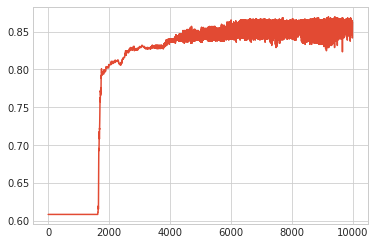

In [343]:
plt.plot(range(nn.epochs), nn.accuracy_history)
plt.show()

As we can see, we got a very decent accuracy of 0.86 on the training set and 0.85 on the test data.
This could probably be improved with some work on tuning the parameters, but for the purposes of this assignment it is satisfactory as it shows that our implementation of a network is functional.


## References

Chapter 6 of Goodfellow, I., Bengio, Y., & Courville, A. (2016).Deep learning. MIT press.Chicago Retrieved from  http://www.deeplearningbook.org/contents/mlp.html 

** Tutorials **
* https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
* https://towardsdatascience.com/neural-net-from-scratch-using-numpy-71a31f6e3675
* https://www.kaggle.com/jamesleslie/titanic-neural-network-for-beginners